In [1]:
#Import of some of the required libraries
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as Soup
import pandas as pd
import hdbscan
from nltk.tokenize import RegexpTokenizer
%matplotlib inline

In [2]:
#Parse the document as xml as specified in the original article
map_coords="doc.kml"
with open(map_coords) as data:
    kml=Soup(data,'lxml-xml')

#Store the coors in coords_list
coords=kml.find_all('coordinates')
coords_list=[]
for c in coords:
    coords_list.append(str(c))
    
#Store the names in names_list
#I still have to fix the encoding of the names
names=kml.find_all('name')
names_list=[]
for n in names:
    names_list.append(str(n)) 

print(coords_list[0])
print(names_list[0])

<coordinates>
            2.28717860000006,48.8629697,0
          </coordinates>
<name>Place du Trocadero</name>


As we can see from the prints above, the cleaning is far from over!
The next cell tokenizes the longitude and latitude and stores them in a numpy array (29x2).

In [3]:
#lat_long is the numpy arrays that contains the lat/long data
tokenizer = RegexpTokenizer('\s+', gaps=True)
treated=[]
for p in coords_list:
    treated.append(tokenizer.tokenize(p))
    treated_2=[]
for i in range (0,len(treated)):
    treated_2.append(treated[i][1])
tokenizer = RegexpTokenizer(',', gaps=True)
lat_long=np.zeros((29,2))
for i in range(0,len(treated_2)):
    lat_long[i][0]=(tokenizer.tokenize(treated_2[i]))[0]
    lat_long[i][1]=(tokenizer.tokenize(treated_2[i]))[1]

print(lat_long[0:3])

[[  2.2871786  48.8629697]
 [  2.3578263  48.8604454]
 [  2.3507857  48.8650948]]


In [4]:
#names is a list that contains the names of the landmarks/touristic places
tokenizer = RegexpTokenizer('>|<', gaps=True)
treated=[]
for p in names_list:
    treated.append(tokenizer.tokenize(p))
names=[]
for i in range (0,len(treated)):
    names.append(treated[i][1])

#df is the data frame that contains each place and its associated latitude and longitude
#df_ct is used to reset df after normalization (more on this later)
d = {'Longitude': lat_long[:,1], 'Latitude': lat_long[:,0],'Place':names}
df = pd.DataFrame(data=d)
df_ct = pd.DataFrame(data=d)

print(names[0:3])
print()
df.head()

['Place du Trocadero', 'Hotel de Soubise', 'Paris-Walks - The Landmarks of Paris tower']



,Latitude,Longitude,Place
0,2.287179,48.862970,Place du Trocadero
1,2.357826,48.860445,Hotel de Soubise
2,2.350786,48.865095,Paris-Walks - The Landmarks of Paris tower
3,2.342508,48.856542,Place Dauphine
4,2.331569,48.872358,Le Lac du Palais Garnier


The above is a snippet of the dataframe

# Sklearn's Kmeans

Snippet of dataframe without normlization:
    Latitude  Longitude                       Place  Cluster
0   2.287179  48.862970          Place du Trocadero        0
18  2.297821  48.864342  Paris Museum of Modern Art        0
17  2.310532  48.875448    MusÃ©e Jacquemart-AndrÃ©        0
13  2.297894  48.860889          Quai Branly Museum        0
28  2.294481  48.858370                Eiffel Tower        0

Snippet of dataframe with normlization:
    Latitude  Longitude                                       Place  Cluster
1   2.357826  48.860445                            Hotel de Soubise        0
2   2.350786  48.865095  Paris-Walks - The Landmarks of Paris tower        0
3   2.342508  48.856542                              Place Dauphine        0
6   2.359793  48.850888                              HÃ´tel Lambert        0
19  2.362285  48.859878                     Picasso National Museum        0


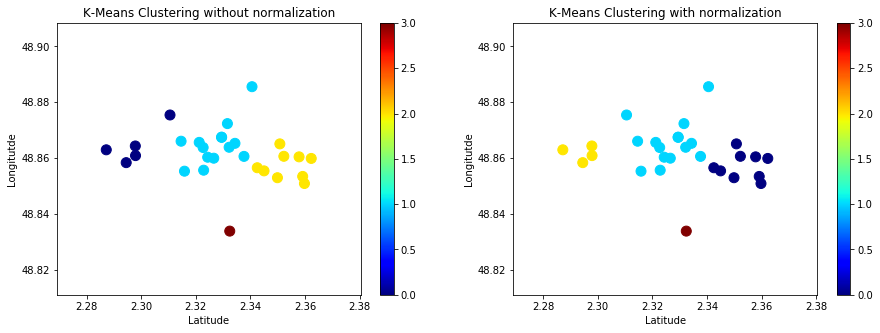

In [5]:
#Sklearn's KMeans with 4 clusters
from sklearn.cluster import KMeans 
kmeans_1 = KMeans(n_clusters=4,n_jobs=-1)
X = df[['Longitude','Latitude']].values
predictions = kmeans_1.fit_predict(X) 
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
scatter = ax.scatter(df_ct['Latitude'],df_ct['Longitude'],
                     c=predictions,s=100,cmap=plt.cm.get_cmap('jet'))
ax.set_title('K-Means Clustering without normalization')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitutde')
plt.colorbar(scatter)
df_ct['Cluster']=predictions
print("Snippet of dataframe without normlization:")
print(df_ct.sort_values(by=['Cluster']).head())
print()
#Uncomment the two following lines if you want to see the labels. Also increase the figsize!
#for i in range(0,29):
   # ax.annotate(df_ct['Place'][i], (df_ct['Latitude'][i],df_ct['Longitude'][i]))


df['Latitude']=(df['Latitude']-df['Latitude'].mean())/(df['Latitude'].max()-df['Latitude'].min())
df['Longitude']=(df['Longitude']-df['Longitude'].mean())/(df['Longitude'].max()-df['Longitude'].min())
X = df[['Longitude','Latitude']].values
predictions = kmeans_1.fit_predict(X) 
ax1 = fig.add_subplot(122)
scatter = ax1.scatter(df_ct['Latitude'],df_ct['Longitude'],
                     c=predictions,s=100,cmap=plt.cm.get_cmap('jet'))
ax1.set_title('K-Means Clustering with normalization')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Longitutde')
plt.colorbar(scatter)
df_ct['Cluster']=predictions
print("Snippet of dataframe with normlization:")
print(df_ct.sort_values(by=['Cluster']).head())
#Uncomment the two following lines if you want to see the labels. Also increase the figsize!
#for i in range(0,29):
   # ax1.annotate(df_ct['Place'][i], (df_ct['Latitude'][i],df_ct['Longitude'][i]))




# Analysis of K-means

* Not much difference is observed.



# HDBSCAN's DBSCAN

Snippet of dataframe without normlization:
    Latitude  Longitude                     Place  Cluster
20  2.340579  48.885587     Montmartre un Village       -1
17  2.310532  48.875448  MusÃ©e Jacquemart-AndrÃ©       -1
4   2.331569  48.872358  Le Lac du Palais Garnier       -1
16  2.314590  48.866048              Petit Palais       -1
15  2.315835  48.855307              Rodin Museum       -1

Snippet of dataframe with normlization:
    Latitude  Longitude                                       Place  Cluster
22  2.344987  48.855420                             Sainte-Chapelle        0
1   2.357826  48.860445                            Hotel de Soubise        0
2   2.350786  48.865095  Paris-Walks - The Landmarks of Paris tower        0
3   2.342508  48.856542                              Place Dauphine        0
19  2.362285  48.859878                     Picasso National Museum        0


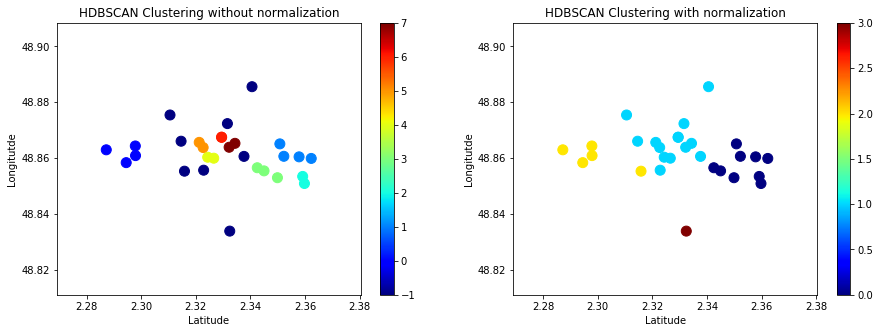

In [6]:
df['Latitude']=df_ct['Latitude']
df['Longitude']=df_ct['Longitude']
rads = np.radians(X)
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric='haversine',)
predictions = clusterer.fit_predict(rads)
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
scatter = ax.scatter(df_ct['Latitude'],df_ct['Longitude'],
                     c=predictions,s=100,cmap=plt.cm.get_cmap('jet'))
ax.set_title('HDBSCAN Clustering without normalization')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitutde')
plt.colorbar(scatter)
df_ct['Cluster']=predictions
#Uncomment the two following lines if you want to see the labels. Also increase the figsize!
#for i in range(0,29):
#    ax.annotate(df_ct['Place'][i], (df_ct['Latitude'][i],df_ct['Longitude'][i]))
print("Snippet of dataframe without normlization:")
print(df_ct.sort_values(by=['Cluster']).head())
print()
df['Latitude']=(df['Latitude']-df['Latitude'].mean())/(df['Latitude'].max()-df['Latitude'].min())
df['Longitude']=(df['Longitude']-df['Longitude'].mean())/(df['Longitude'].max()-df['Longitude'].min())
X = df[['Longitude','Latitude']].values
predictions = kmeans_1.fit_predict(X) 
ax1 = fig.add_subplot(122)
scatter = ax1.scatter(df_ct['Latitude'],df_ct['Longitude'],
                     c=predictions,s=100,cmap=plt.cm.get_cmap('jet'))
ax1.set_title('HDBSCAN Clustering with normalization')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Longitutde')
plt.colorbar(scatter)
df_ct['Cluster']=predictions
#Uncomment the two following lines if you want to see the labels. Also increase the figsize!
#for i in range(0,29):
#    ax1.annotate(df_ct['Place'][i], (df_ct['Latitude'][i],df_ct['Longitude'][i]))
print("Snippet of dataframe with normlization:")
print(df_ct.sort_values(by=['Cluster']).head())

# Analysis of HDBSCAN's DBSCAN

* There is a difference!
* Without normalization the DBSCAN seems to overfit some of the middle points by creating more clusters and labels more points as noise (-1) than it's normalized counterpart. 
* Try increasing min_cluster_size to 3 and see what happens: Most points will be assigned to one cluster.




# Sklearn's DBSCAN

Snippet of dataframe without normlization:
    Latitude  Longitude                     Place  Cluster
0   2.287179  48.862970        Place du Trocadero       -1
20  2.340579  48.885587     Montmartre un Village       -1
27  2.332422  48.833832        Catacombs of Paris       -1
17  2.310532  48.875448  MusÃ©e Jacquemart-AndrÃ©       -1
1   2.357826  48.860445          Hotel de Soubise        0

Snippet of dataframe with normlization:
    Latitude  Longitude                     Place  Cluster
0   2.287179  48.862970        Place du Trocadero       -1
17  2.310532  48.875448  MusÃ©e Jacquemart-AndrÃ©       -1
27  2.332422  48.833832        Catacombs of Paris       -1
20  2.340579  48.885587     Montmartre un Village       -1
10  2.352245  48.860642       The Centre Pompidou        0


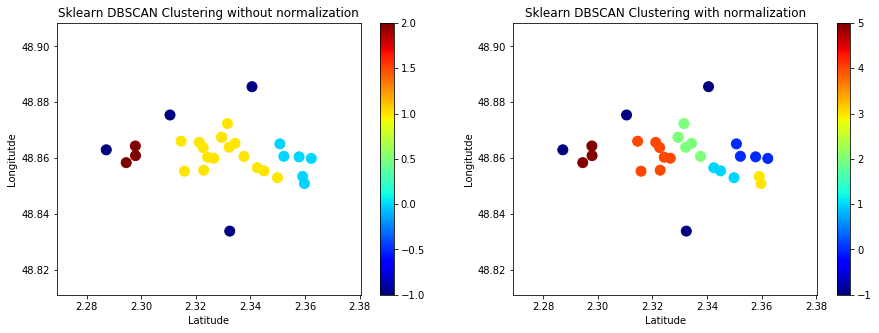

In [7]:
df['Latitude']=df_ct['Latitude']
df['Longitude']=df_ct['Longitude']
from sklearn.cluster import DBSCAN 
kmeans_1 = DBSCAN(eps=0.008,min_samples=2,n_jobs=-1)
X = df[['Longitude','Latitude']].values
predictions = kmeans_1.fit_predict(X) 
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
scatter = ax.scatter(df_ct['Latitude'],df_ct['Longitude'],
                     c=predictions,s=100,cmap=plt.cm.get_cmap('jet'))
ax.set_title('Sklearn DBSCAN Clustering without normalization')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitutde')
plt.colorbar(scatter)
df_ct['Cluster']=predictions
#Uncomment the two following lines if you want to see the labels. Also increase the figsize!
#for i in range(0,29):
 #   ax.annotate(df_ct['Place'][i], (df_ct['Latitude'][i],df_ct['Longitude'][i]))
print("Snippet of dataframe without normlization:")
print(df_ct.sort_values(by=['Cluster']).head())
print()
df['Latitude']=(df['Latitude']-df['Latitude'].mean())/(df['Latitude'].max()-df['Latitude'].min())
df['Longitude']=(df['Longitude']-df['Longitude'].mean())/(df['Longitude'].max()-df['Longitude'].min())
kmeans_1 = DBSCAN(eps=0.1,min_samples=2,n_jobs=-1)
X = df[['Longitude','Latitude']].values
predictions = kmeans_1.fit_predict(X) 
ax1 = fig.add_subplot(122)
scatter = ax1.scatter(df_ct['Latitude'],df_ct['Longitude'],
                     c=predictions,s=100,cmap=plt.cm.get_cmap('jet'))
ax1.set_title('Sklearn DBSCAN Clustering with normalization')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Longitutde')
plt.colorbar(scatter)
df_ct['Cluster']=predictions
#Uncomment the two following lines if you want to see the labels. Also increase the figsize!
#for i in range(0,29):
 #   ax1.annotate(df_ct['Place'][i], (df_ct['Latitude'][i],df_ct['Longitude'][i]))
print("Snippet of dataframe with normlization:")
print(df_ct.sort_values(by=['Cluster']).head())

# Analysis of sklearn's DBSCAN

* There is a difference!
* Underfitting is clear in the unnormalized clustering. The normalized one seems more sensible.


# Sklearn's MeanShift

Snippet of dataframe without normlization:
    Latitude  Longitude                     Place  Cluster
14  2.322672  48.863788          Orangerie Museum        0
23  2.321236  48.865633      Place de la Concorde        0
24  2.329432  48.867471            Place VendÃ´me        0
17  2.310532  48.875448  MusÃ©e Jacquemart-AndrÃ©        0
16  2.314590  48.866048              Petit Palais        0

Snippet of dataframe with normlization:
    Latitude  Longitude                 Place  Cluster
14  2.322672  48.863788      Orangerie Museum        0
23  2.321236  48.865633  Place de la Concorde        0
24  2.329432  48.867471        Place VendÃ´me        0
16  2.314590  48.866048          Petit Palais        0
15  2.315835  48.855307          Rodin Museum        0


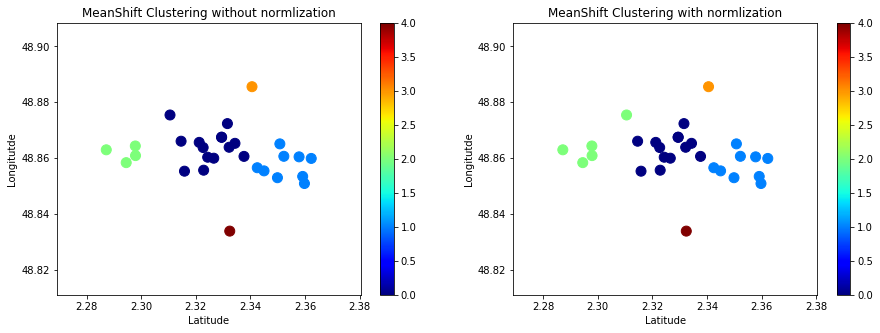

In [8]:
df['Latitude']=df_ct['Latitude']
df['Longitude']=df_ct['Longitude']
from sklearn.cluster import MeanShift 
kmeans_1 = MeanShift(min_bin_freq =2,n_jobs=-1)
X = df[['Longitude','Latitude']].values
predictions = kmeans_1.fit_predict(X) 
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
scatter = ax.scatter(df_ct['Latitude'],df_ct['Longitude'],
                     c=predictions,s=100,cmap=plt.cm.get_cmap('jet'))
ax.set_title('MeanShift Clustering without normlization')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitutde')
plt.colorbar(scatter)
df_ct['Cluster']=predictions
#Uncomment the two following lines if you want to see the labels. Also increase the figsize!
#for i in range(0,29):
#    ax.annotate(df_ct['Place'][i], (df_ct['Latitude'][i],df_ct['Longitude'][i]))
print("Snippet of dataframe without normlization:")
print(df_ct.sort_values(by=['Cluster']).head())
print()

df['Latitude']=(df['Latitude']-df['Latitude'].mean())/(df['Latitude'].max()-df['Latitude'].min())
df['Longitude']=(df['Longitude']-df['Longitude'].mean())/(df['Longitude'].max()-df['Longitude'].min())
X = df[['Longitude','Latitude']].values
predictions = kmeans_1.fit_predict(X) 
ax1 = fig.add_subplot(122)
scatter = ax1.scatter(df_ct['Latitude'],df_ct['Longitude'],
                     c=predictions,s=100,cmap=plt.cm.get_cmap('jet'))
ax1.set_title('MeanShift Clustering with normlization')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Longitutde')
plt.colorbar(scatter)
df_ct['Cluster']=predictions
#Uncomment the two following lines if you want to see the labels. Also increase the figsize!
#for i in range(0,29):
#    ax1.annotate(df_ct['Place'][i], (df_ct['Latitude'][i],df_ct['Longitude'][i]))
print("Snippet of dataframe with normlization:")
print(df_ct.sort_values(by=['Cluster']).head())


# Analysis of sklearn's MeanShift

* Minimal difference is observed


# Sklearn's SpectralClustering

Snippet of dataframe without normlization:
    Latitude  Longitude                       Place  Cluster
0   2.287179  48.862970          Place du Trocadero        0
18  2.297821  48.864342  Paris Museum of Modern Art        0
15  2.315835  48.855307                Rodin Museum        0
27  2.332422  48.833832          Catacombs of Paris        0
13  2.297894  48.860889          Quai Branly Museum        0

Snippet of dataframe with normlization:
    Latitude  Longitude                       Place  Cluster
0   2.287179  48.862970          Place du Trocadero        0
18  2.297821  48.864342  Paris Museum of Modern Art        0
13  2.297894  48.860889          Quai Branly Museum        0
28  2.294481  48.858370                Eiffel Tower        0
22  2.344987  48.855420             Sainte-Chapelle        1


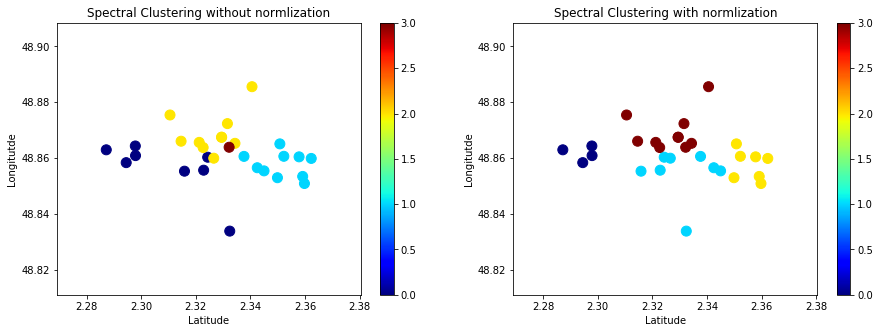

In [9]:
df['Latitude']=df_ct['Latitude']
df['Longitude']=df_ct['Longitude']
from sklearn.cluster import SpectralClustering 
kmeans_1 = SpectralClustering(n_clusters =4,n_jobs=-1)
X = df[['Longitude','Latitude']].values
predictions = kmeans_1.fit_predict(X) 
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
scatter = ax.scatter(df_ct['Latitude'],df_ct['Longitude'],
                     c=predictions,s=100,cmap=plt.cm.get_cmap('jet'))
ax.set_title('Spectral Clustering without normlization')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitutde')
plt.colorbar(scatter)
df_ct['Cluster']=predictions
#Uncomment the two following lines if you want to see the labels. Also increase the figsize!
#for i in range(0,29):
#    ax.annotate(df_ct['Place'][i], (df_ct['Latitude'][i],df_ct['Longitude'][i]))
#fig.savefig('Spectral.png')
print("Snippet of dataframe without normlization:")
print(df_ct.sort_values(by=['Cluster']).head())
print()
df['Latitude']=(df['Latitude']-df['Latitude'].mean())/(df['Latitude'].max()-df['Latitude'].min())
df['Longitude']=(df['Longitude']-df['Longitude'].mean())/(df['Longitude'].max()-df['Longitude'].min())
X = df[['Longitude','Latitude']].values
predictions = kmeans_1.fit_predict(X) 
ax1 = fig.add_subplot(122)
scatter = ax1.scatter(df_ct['Latitude'],df_ct['Longitude'],
                     c=predictions,s=100,cmap=plt.cm.get_cmap('jet'))
ax1.set_title('Spectral Clustering with normlization')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Longitutde')
plt.colorbar(scatter)
df_ct['Cluster']=predictions
#Uncomment the two following lines if you want to see the labels. Also increase the figsize!
#for i in range(0,29):
#    ax1.annotate(df_ct['Place'][i], (df_ct['Latitude'][i],df_ct['Longitude'][i]))
#fig.savefig('Spectral.png')
print("Snippet of dataframe with normlization:")
print(df_ct.sort_values(by=['Cluster']).head())

# Analysis of sklearn's spectral clustering

* There is a difference!
* The unnormalized clustering has some weird behaviors. Why isn't the brown point labelled as yellow? 
* The normalized clustering seems more sensible.


# Sklearn's AgglomerativeClustering

Snippet of dataframe without normlization:
    Latitude  Longitude                                       Place  Cluster
1   2.357826  48.860445                            Hotel de Soubise        0
2   2.350786  48.865095  Paris-Walks - The Landmarks of Paris tower        0
3   2.342508  48.856542                              Place Dauphine        0
26  2.349902  48.852968             CathÃ©drale Notre-Dame de Paris        0
22  2.344987  48.855420                             Sainte-Chapelle        0

Snippet of dataframe with normlization:
    Latitude  Longitude                                       Place  Cluster
22  2.344987  48.855420                             Sainte-Chapelle        0
1   2.357826  48.860445                            Hotel de Soubise        0
2   2.350786  48.865095  Paris-Walks - The Landmarks of Paris tower        0
3   2.342508  48.856542                              Place Dauphine        0
19  2.362285  48.859878                     Picasso National Museum  

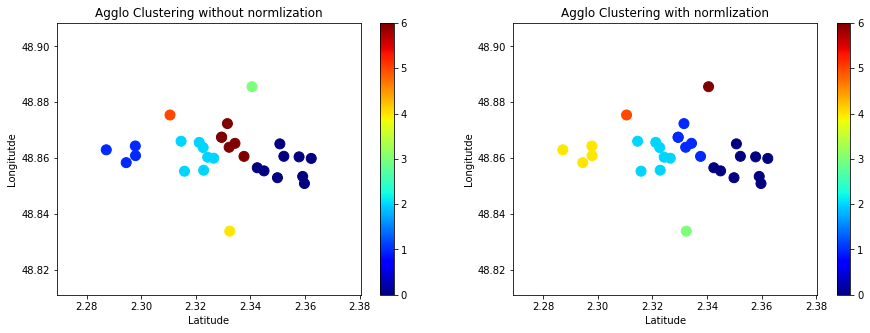

In [13]:
df['Latitude']=df_ct['Latitude']
df['Longitude']=df_ct['Longitude']
from sklearn.cluster import AgglomerativeClustering 
kmeans_1 = AgglomerativeClustering(n_clusters =7,affinity='manhattan',linkage='average')
X = df[['Longitude','Latitude']].values
predictions = kmeans_1.fit_predict(X) 
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
scatter = ax.scatter(df_ct['Latitude'],df_ct['Longitude'],
                     c=predictions,s=100,cmap=plt.cm.get_cmap('jet'))
ax.set_title('Agglo Clustering without normlization')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitutde')
plt.colorbar(scatter)
df_ct['Cluster']=predictions
#Uncomment the two following lines if you want to see the labels. Also increase the figsize!
#for i in range(0,29):
#    ax.annotate(df_ct['Place'][i], (df_ct['Latitude'][i],df_ct['Longitude'][i]))
#fig.savefig('Agglo.png')
print("Snippet of dataframe without normlization:")
print(df_ct.sort_values(by=['Cluster']).head())
print()

df['Latitude']=(df['Latitude']-df['Latitude'].mean())/(df['Latitude'].max()-df['Latitude'].min())
df['Longitude']=(df['Longitude']-df['Longitude'].mean())/(df['Longitude'].max()-df['Longitude'].min())
X = df[['Longitude','Latitude']].values
predictions = kmeans_1.fit_predict(X) 
ax1 = fig.add_subplot(122)
scatter = ax1.scatter(df_ct['Latitude'],df_ct['Longitude'],
                     c=predictions,s=100,cmap=plt.cm.get_cmap('jet'))
ax1.set_title('Agglo Clustering with normlization')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Longitutde')
plt.colorbar(scatter)
df_ct['Cluster']=predictions
#Uncomment the two following lines if you want to see the labels. Also increase the figsize!
#for i in range(0,29):
#    ax1.annotate(df_ct['Place'][i], (df_ct['Latitude'][i],df_ct['Longitude'][i]))
#fig.savefig('Spectral.png')
print("Snippet of dataframe with normlization:")
print(df_ct.sort_values(by=['Cluster']).head())

# Analysis of sklearn's agglomerative clustering

* Both look more or less the same with the same number of clusters.


# Conclusion

* Where I think normalization didn't help much: Agglomerative clustering, MeanShift, K-means
* Where I think it helped: Spectral clustering, DBSCAN
* Where I think it made things worse: N/A

* On a final note, these results are relative to the hyperparameters of the function which, if tweaked, could totally change the results.
